<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Exercise_7_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN cifar**

In [1]:
!pip3 install torch torchvision

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

**Loading data**

In [26]:
normalization = .5, .5, .5
batch_size = 64

transform_train = tv.transforms.Compose([
  tv.transforms.RandomHorizontalFlip(),
  tv.transforms.ColorJitter(.1, .1, .1, .1),
  tv.transforms.RandomAffine(degrees = 10, translate=(0.1, 0.1), scale=(.9, 1.1), shear=20),
  tv.transforms.ToTensor(),
  tv.transforms.Normalize(normalization, normalization)
])
transforms_test = tv.transforms.Compose([
  tv.transforms.ToTensor(),
  tv.transforms.Normalize(normalization, normalization)                                         
])
dataset_train = tv.datasets.CIFAR10('.', train = True, download = True, transform = transform_train)
dataset_test = tv.datasets.CIFAR10('.', train = False, download = True, transform = transforms_test)
loader_train = t.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True, num_workers = 4)
loader_test = t.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = False, num_workers = 4)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar10_labels = 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

def to_numpy(x):
  return x.cpu().detach().numpy()

def plot_img(img, predicted_label, true_label):
  img = to_numpy(img)
  img = np.transpose(img, (1, 2, 0))
  img = img * normalization + normalization
  plt.title(cifar10_labels[predicted_label], color = 'green' if predicted_label == true_label else 'red')
  plt.imshow(img)

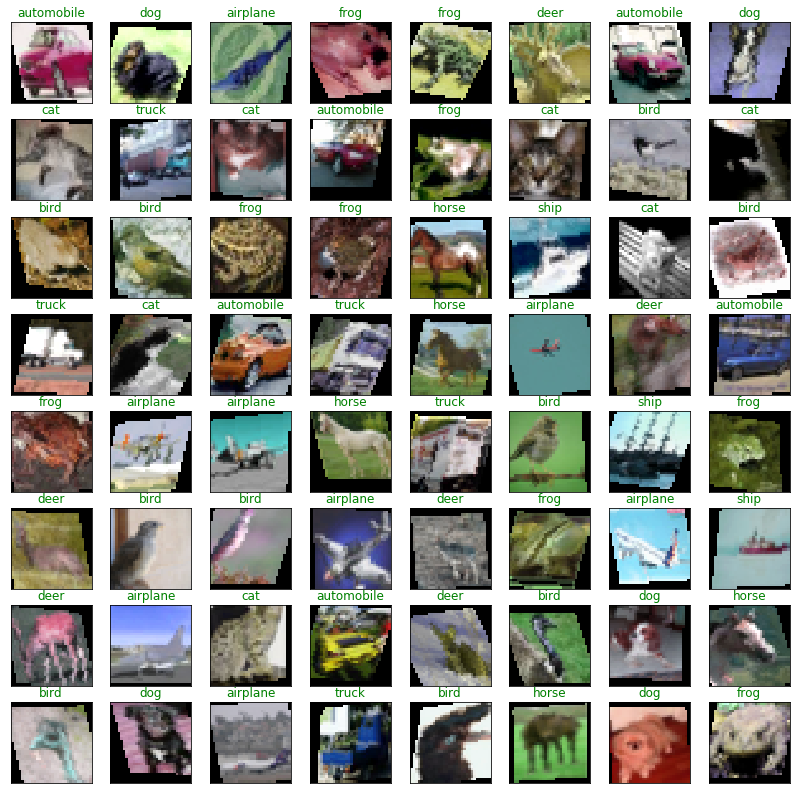

In [28]:
imgs, labels = next(iter(loader_train))

fig = plt.figure(figsize=(14, 14))
for i in range(batch_size):
  fig.add_subplot(8, 8, i + 1, xticks = [], yticks = [])
  plot_img(imgs[i], labels[i], labels[i])

**Define model**

In [0]:
model = t.nn.Sequential(
    t.nn.BatchNorm2d(3),
    t.nn.Dropout2d(p=0.1),
    t.nn.Conv2d(3, 32, 3, padding = 1), # img size 32
    t.nn.ReLU(),
   
    t.nn.BatchNorm2d(32),
    t.nn.Dropout2d(p=0.2),
    t.nn.Conv2d(32, 64, 3, padding = 1), # img size 32
    t.nn.MaxPool2d(2, stride=2), # img size 16
    t.nn.ReLU(),

    t.nn.BatchNorm2d(64),
    t.nn.Dropout2d(p=0.2),
    t.nn.Conv2d(64, 128, 3, padding = 1), # img size 16
    t.nn.ReLU(),

    t.nn.BatchNorm2d(128),
    t.nn.Dropout2d(p=0.3),
    t.nn.Conv2d(128, 256, 3, padding = 1), # img size 16
    t.nn.MaxPool2d(2, stride=2), # img size 8
    t.nn.ReLU(),

    t.nn.BatchNorm2d(256),
    t.nn.Dropout2d(p=0.3),
    t.nn.Conv2d(256, 32, 3, padding = 1), # img size 8
    t.nn.ReLU(),

    t.nn.BatchNorm2d(32),
    t.nn.Flatten(),
    t.nn.Dropout(p=0.4),
    t.nn.Linear(8 * 8 * 32, 512),
    t.nn.ReLU(),

    t.nn.Dropout(p=0.3),
    t.nn.Linear(512, 128),
    t.nn.ReLU(),

    t.nn.Linear(128, 10)    
)
model = model.cuda()

**Training**

In [0]:
def accuracy(y_pred, y):
  vals, pos = t.max(y_pred, 1)
  return t.sum(pos == y).item() / len(y)

In [31]:
epochs = 100
optimizer = t.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = t.nn.CrossEntropyLoss()
losses_train, losses_test = [], []
accuracies_train, accuracies_test = [], []
len_train, len_test = len(loader_train), len(loader_test)

for epoch in range(epochs):
  epoch_train_loss, epoch_test_loss, epoch_train_acc, epoch_test_acc = 0, 0, 0, 0
  
  # Train
  model.train()
  for x, y in loader_train:
    y_pred = model.forward(x.cuda())
    y = y.cuda()
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_train_loss += loss.item()
    epoch_train_acc += accuracy(y_pred, y)
  losses_train.append(epoch_train_loss / len_train)
  accuracies_train.append(epoch_train_acc / len_train)

  # Test
  model.eval()
  with t.no_grad():
    for x, y in loader_test:
      y_pred = model.forward(x.cuda())
      y = y.cuda()
      loss = loss_fn(y_pred, y)
      epoch_test_loss += loss.item()
      epoch_test_acc += accuracy(y_pred, y)
  losses_test.append(epoch_test_loss / len_test)
  accuracies_test.append(epoch_test_acc / len_test)

  print('Epoch {} train acc {} test acc {} train loss {} test loss {}'.format(
      epoch + 1, epoch_train_acc / len_train, epoch_test_acc / len_test, epoch_train_loss / len_train, epoch_test_loss / len_test))

Epoch 1 train acc 0.3789162404092072 test acc 0.5615047770700637 train loss 1.7032268440631955 test loss 1.205557595392701
Epoch 2 train acc 0.4944053708439898 test acc 0.6310708598726115 train loss 1.4135520174680158 test loss 1.0310828826230043
Epoch 3 train acc 0.5497122762148338 test acc 0.6798367834394905 train loss 1.271150135551877 test loss 0.8996554260041304
Epoch 4 train acc 0.5816416240409207 test acc 0.7096934713375797 train loss 1.178807203803221 test loss 0.82280417365633
Epoch 5 train acc 0.6068773976982097 test acc 0.7202428343949044 train loss 1.120263170708171 test loss 0.7837135009704881
Epoch 6 train acc 0.6227022058823529 test acc 0.7442277070063694 train loss 1.0776858973838483 test loss 0.7283141757272611
Epoch 7 train acc 0.636349104859335 test acc 0.7557722929936306 train loss 1.0378699724174216 test loss 0.702945665189415
Epoch 8 train acc 0.6483375959079284 test acc 0.7767714968152867 train loss 1.007252812690442 test loss 0.653785220946476
Epoch 9 train acc 

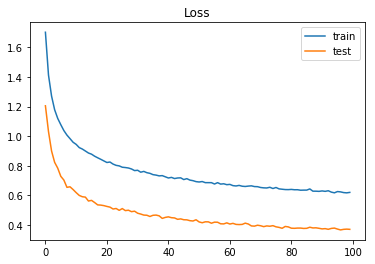

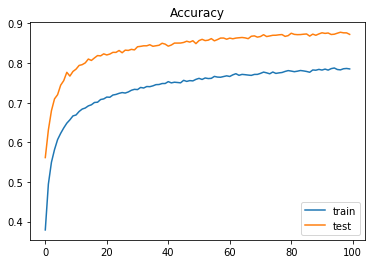

In [32]:
plt.plot(range(epochs), losses_train, label = 'train')
plt.plot(range(epochs), losses_test, label = 'test')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(range(epochs), accuracies_train, label = 'train')
plt.plot(range(epochs), accuracies_test, label = 'test')
plt.legend()
plt.title('Accuracy')
plt.show()